# Data exploration

## Set up environment

### Download dataset manually

Let's start downloading the train dataset from Kaggle's website:

https://www.kaggle.com/c/nlp-getting-started/data

I downloaded the dataset manually and saved if in the 'input' folder.

The dataset could be downloaded programmatically using Kaggle API, but it requires authentication and it would be unsafe on a notebook that is meant to be shared.

### Import Python packages

For data exploration and processing we are using the following Python packages:
* Numpy (linear algebra)
* Pandas (data processing)
* Seaborn (data visualization)
* Matplotlib (data visualization)

In [1]:
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Read dataset from CSV

Print out the first line of the file to see what fields it contains.

In [2]:
with open('input/train.csv') as f:
    print(next(f))

id,keyword,location,text,target



Read the CSV file. Looks like 'id' is the right column to be our index.

In [3]:
# Read dataset
df = pd.read_csv('input/train.csv', encoding = 'ISO-8859-1', index_col='id')

## Dataset analysis

### General overview

Taking a look at the first rows of the dataset.

In [4]:
df.sample(n=6)

,keyword,location,text,target
id,,,,
3335,demolished,NaN,Take this China get demolished and sent back t...,0
947,blaze,ducked off . . .,niggas love hating.,0
9175,suicide%20bomber,africa,Suicide Bomber Kills More Than a Dozen in Saud...,1
3989,devastation,Washington DC,Fascinating pics from inside North Korea. Not ...,0
9883,traumatised,NaN,@disneyIrh so traumatised im ???? http://t.co/...,1
2440,collide,"Pennsylvania, USA",Worlds Collide When an American Family Takes O...,0


The four columns are:

* keyword: A keyword from that tweet (it might be blank)
* location: The location the tweet was sent from (it might be blank)
* text: The text of a tweet
* target: 1 for disaster-related, 0 otherwise

## Number of disaster tweets

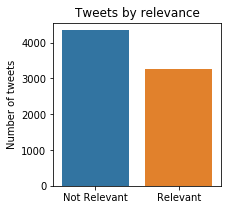

Total tweets: 7613
Disaster-related tweets: 3271
Non-disaster related tweets: 4342
Percentage of disaster-related tweets: 43.0 %


In [5]:
[label_0, label_1] = df['target'].value_counts()

plt.figure(figsize=(3,3))
# Add title
plt.title('Tweets by relevance')
# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=['Not Relevant', 'Relevant'], y=[label_0, label_1])
# Add label for vertical axis
plt.ylabel('Number of tweets')
plt.show()

print('Total tweets:', len(df))
print('Disaster-related tweets:', label_1)
print('Non-disaster related tweets:', label_0)
print('Percentage of disaster-related tweets:', '{:.1f}'.format(100*label_1/(label_0 + label_1)), '%')

## Text

About disasters:

In [6]:
df[df['target']== 1].sample(n=3)['text'].tolist()

["Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by SÂ\x89Ã\x9b_ http://t.co/JDVSGVhlIs",
 '24 killed in two simultaneous rail crash as acute floods derail the two trains #India #mumbai... http://t.co/4KBWPCmMbM',
 'Check out my Lava lamp dude ???? http://t.co/To9ViqooFv']

Not about disasters:

In [7]:
df[df['target']== 0].sample(n=3)['text'].tolist()

["Moved on to 'Bang Bang Rock and Roll' by @Art_Brut_ . It's been too long since I've played this one loud. ART BRUT TOP OF THE POPS.",
 '@Chrisman528 fatality ...',
 '@TheNissonian @RejectdCartoons nissan are you ok do you need medical assistance i can call an ambulance if you need me to']

## Keyword distribution

Keywords are the search terms used to retrieve the tweets to build the dataset. This keyword is NOT part of a tweet and it will not be available when we use our model to classify new tweets. For this reason I am not going to use it to build the model.

Let's take a look at it nonetheless to see what it looks like.

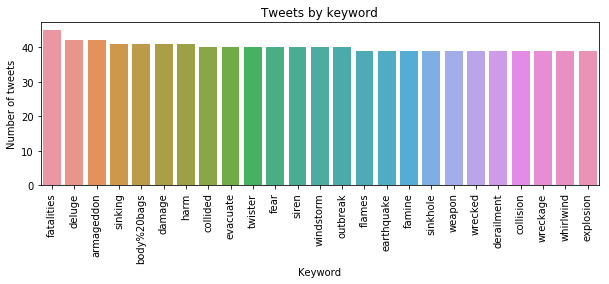

Total different keywords: 221
Average number of tweets per keyword: 34.171945701357465
Standard deviation: 1.3833293172632466
Number of tweets with no keyword: 61


In [8]:
keyword_count = df['keyword'].value_counts()[:25]
plt.figure(figsize=(10,3))
graph = sns.barplot(keyword_count.index, keyword_count.values)
plt.title('Tweets by keyword')
plt.ylabel('Number of tweets')
plt.xlabel('Keyword')
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
plt.show()
print('Total different keywords:', df['keyword'].nunique(dropna=True))
print('Average number of tweets per keyword:', np.average(df['keyword'].value_counts()))
print('Standard deviation:', np.std(keyword_count.values))
print('Number of tweets with no keyword:', len(df) - df['keyword'].count())

We can see that there are a total of 221 different keywords in the dataset. Each keyword has an average of 34.2 tweets and a standard deviation of 1.39, so they are pretty evenly distributed.

## Most popular locations

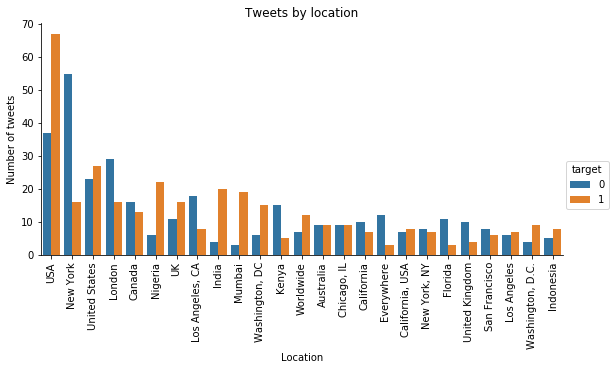

Total different locations: 3341


In [9]:
# Get the most popular locations by number of tweets
location_count = df['location'].value_counts()[:25]

# Count tweets from the most popular locations keeping relevant and irrelevant counts separate
target_by_location = df.loc[df['location'].isin(location_count.index)].groupby(['location', 'target']).size().reset_index(name='count')

# Order results
sorterIndex = dict(zip(location_count.index, range(len(location_count.index))))
target_by_location['position'] = target_by_location['location'].map(sorterIndex)
target_by_location.sort_values(['position'], inplace = True)

# Plot results
graph = sns.factorplot(x='location', y='count', hue='target', data=target_by_location, kind='bar', aspect=2)
plt.title('Tweets by location')
plt.ylabel('Number of tweets')
plt.xlabel('Location')
graph.set_axis_labels('Location', 'Number of tweets').set_xticklabels(graph.facet_axis(0, 0).get_xticklabels(), rotation=90)
plt.show()
print('Total different locations:', df['location'].nunique(dropna=True))

There are a total of 3,341 different locations for 7,613 tweets.

We need to keep in mind that locations can be very inaccurate:
*  They are user defined, and the user can write anything.
*  They are strings with no meaning. "USA" and "United States" are different locations, "California" is not contained in "USA", neither is "Los Angeles", and "Los Angeles, CA" is a completely different location.

However, looking at the graph above it looks like there is a tendency of some places to produce more or less "disaster" tweets than the dataset average, so it might be worth using it in our model. Having 3,341 locations for 7,613 tweets implies that most locations will be irrelevant for not having enough tweets from them to extract patterns.

## Hyperlinks

Hyperlinks are unique to each tweet and do not provide any meaningful information to differenciate one tweet from another. What might be meaningful is whether a tweet contains a hyperlink or not.

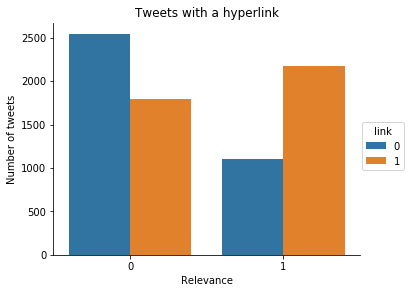

In [12]:
import re

df['link'] = np.nan

for index, row in df.iterrows():
    link = re.findall(r'http\S+', row['text'])
    if len(link) > 0:
        df.loc[index, 'link'] = np.int(1)
    else:
        df.loc[index, 'link'] = np.int(0)

df = df.astype({'link': int})

# Plot results
link_count = df.groupby(['link', 'target']).size().reset_index(name='count')
graph = sns.factorplot(x='target', y='count', hue='link', data=link_count, kind='bar', aspect=1.3)
plt.title('Tweets with a hyperlink')
plt.ylabel('Number of tweets')
plt.xlabel('Relevance')
plt.show()